<a href="https://colab.research.google.com/github/Chao-Meng/optimization/blob/main/Phase1%262_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

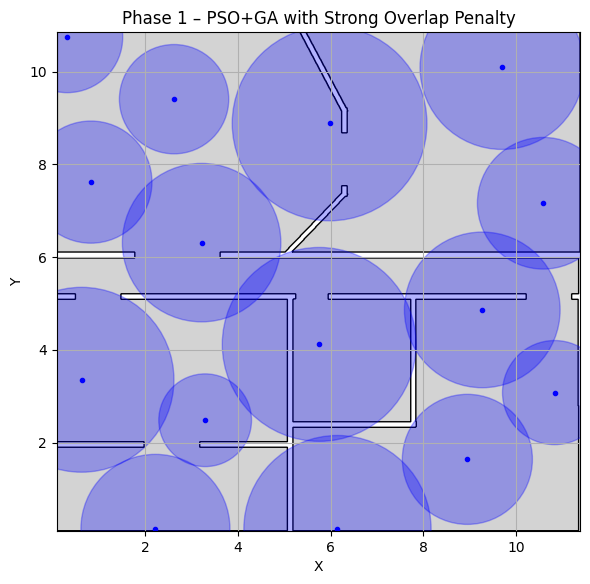

In [1]:
#####phaseone to get sensor.json PSO+GA
import numpy as np
import matplotlib.pyplot as plt
import json
from matplotlib.patches import Polygon
from matplotlib.path import Path

# --------------------- Load Layout ---------------------
with open("layout.json", "r") as f:
    layout_data = json.load(f)

polygon_coords = layout_data["verts"]
min_x, min_y   = layout_data["bbox"]["min"]
max_x, max_y   = layout_data["bbox"]["max"]
layout_poly    = Path(polygon_coords)

# --------------------- Parameters ---------------------
num_sensors         = 15
sensor_radius_bounds = (1.0, 2.5)
num_particles       = 30
num_iterations      = 80

# PSO+GA hyperparams
w_inertia     = 0.7
c1, c2        = 1.4, 1.4
ga_generations = 5
mutation_rate  = 0.1

# Overlap penalty weight (increased) & overlap‑point penalty & radius cost
w_overlap      = 2.0    # Previously set to 0.5; raised
w_overlap_pts  = 1.0    # New: penalty for each grid point covered by two or more sensors
w_radius       = 0.1

# --------------------- Prepare Grid ---------------------
grid_resolution = 0.2
x_coords = np.arange(min_x, max_x, grid_resolution)
y_coords = np.arange(min_y, max_y, grid_resolution)
xx, yy  = np.meshgrid(x_coords, y_coords)
GRID    = np.c_[xx.ravel(), yy.ravel()]
valid   = layout_poly.contains_points(GRID)

# --------------------- Fitness Function ---------------------
def evaluate_solution(sol):
    cov = np.zeros(len(GRID), dtype=int)
    radius_cost = 0.0

    # Cumulative coverage and radius cost
    for i in range(num_sensors):
        x, y, r = sol[3*i:3*i+3]
        if not layout_poly.contains_point((x, y)):
            return np.inf
        d = np.hypot(GRID[:,0]-x, GRID[:,1]-y)
        mask = (d <= r)
        cov += mask.astype(int)
        radius_cost += r

    cov = cov * valid
    unique_cov   = np.sum(cov > 0)
    overlap_cov  = np.sum(cov) - unique_cov
    overlap_pts  = np.sum(cov > 1)  # Number of grid points covered by at least two sensors

    # Objective: minimize the following expression
    #  - unique_cov   (max coverage)
    #  + w_overlap*overlap_cov
    #  + w_overlap_pts*overlap_pts
    #  + w_radius*radius_cost
    fitness = (
        - unique_cov
        + w_overlap * overlap_cov
        + w_overlap_pts * overlap_pts
        + w_radius * radius_cost
    )
    return fitness

# --------------------- PSO + GA Setup ---------------------
dim = num_sensors * 3
lb  = np.tile([min_x, min_y, sensor_radius_bounds[0]], num_sensors)
ub  = np.tile([max_x, max_y, sensor_radius_bounds[1]], num_sensors)

# Initialize particles
pos    = np.random.uniform(lb, ub, (num_particles, dim))
vel    = np.zeros_like(pos)
pbest  = pos.copy()
pval   = np.array([evaluate_solution(p) for p in pos])
gbest  = pbest[np.argmin(pval)].copy()
gval   = np.min(pval)

# --------------------- Hybrid PSO + GA Loop ---------------------
for _ in range(num_iterations):
    # PSO update
    for i in range(num_particles):
        r1, r2 = np.random.rand(dim), np.random.rand(dim)
        vel[i] = (
            w_inertia * vel[i]
            + c1 * r1 * (pbest[i] - pos[i])
            + c2 * r2 * (gbest - pos[i])
        )
        pos[i] += vel[i]
        pos[i] = np.minimum(np.maximum(pos[i], lb), ub)

        f = evaluate_solution(pos[i])
        if f < pval[i]:
            pval[i] = f
            pbest[i] = pos[i].copy()
            if f < gval:
                gval = f
                gbest = pos[i].copy()

    # GA local refinement
    for _ in range(ga_generations):
        i1, i2 = np.random.choice(num_particles, 2, replace=False)
        p1, p2 = pbest[i1], pbest[i2]
        cp = np.random.randint(1, dim)
        child = np.concatenate([p1[:cp], p2[cp:]])
        # Mutation
        m = np.random.rand(dim) < mutation_rate
        child[m] += np.random.normal(scale=0.1, size=m.sum()) * (ub[m] - lb[m])
        child = np.minimum(np.maximum(child, lb), ub)

        f_child = evaluate_solution(child)
        if f_child < gval:
            gval = f_child
            gbest = child.copy()

# --------------------- Save Phase 1 result ---------------------
sensor_positions = []
for i in range(num_sensors):
    x, y, r = gbest[3*i:3*i+3]
    sensor_positions.append([x, y, r])

with open("phase1_sensors.json", "w") as f:
    json.dump({"sensors": sensor_positions}, f, indent=2)

# --------------------- Visulasition ---------------------
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect("equal")
ax.add_patch(Polygon(polygon_coords,
                     closed=True,
                     facecolor="lightgray",
                     edgecolor="black"))

for x, y, r in sensor_positions:
    ax.add_patch(plt.Circle((x, y), r,
                            color='blue', alpha=0.3))
    ax.plot(x, y, 'bo', markersize=3)

plt.title("Phase 1 – PSO+GA with Strong Overlap Penalty")
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.xlabel("X"); plt.ylabel("Y")
plt.grid(True)
plt.tight_layout()
plt.show()


Enter activity levels (0.0–1.0):

– Morning
  Living_Room: 0.1
  Kitchen: 0.5
  Room: 0.1
  Bedroom: 0.4
  Toilet: 0.8
  Bathroom: 0.8
  Gym: 0.9

– Afternoon
  Living_Room: 0.1
  Kitchen: 0
  Room: 0
  Bedroom: 0.1
  Toilet: 0.4
  Bathroom: 0.4
  Gym: 0.9

– Evening
  Living_Room: 1
  Kitchen: 0.8
  Room: 0.2
  Bedroom: 0.1
  Toilet: 0.3
  Bathroom: 0.3
  Gym: 0.9

– Night
  Living_Room: 0
  Kitchen: 0
  Room: 0
  Bedroom: 1
  Toilet: 0.3
  Bathroom: 0.3
  Gym: 0

Final activity levels:
{'Afternoon': {'Bathroom': 0.4,
               'Bedroom': 0.1,
               'Gym': 0.9,
               'Kitchen': 0.0,
               'Living_Room': 0.1,
               'Room': 0.0,
               'Toilet': 0.4},
 'Evening': {'Bathroom': 0.3,
             'Bedroom': 0.1,
             'Gym': 0.9,
             'Kitchen': 0.8,
             'Living_Room': 1.0,
             'Room': 0.2,
             'Toilet': 0.3},
 'Morning': {'Bathroom': 0.8,
             'Bedroom': 0.4,
             'Gym': 0.9,
       

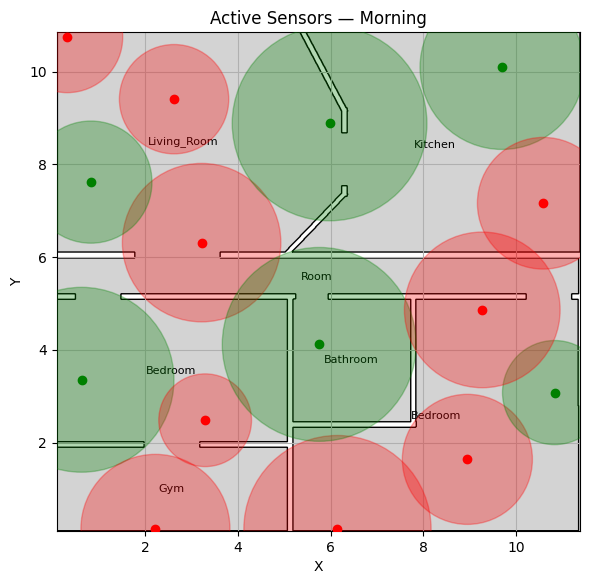

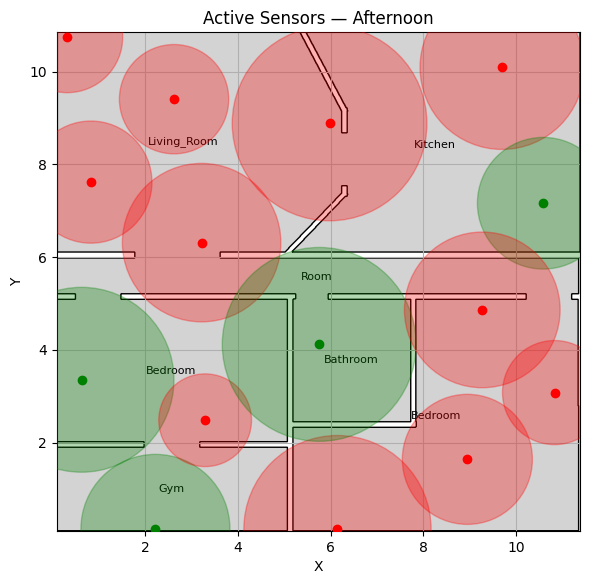

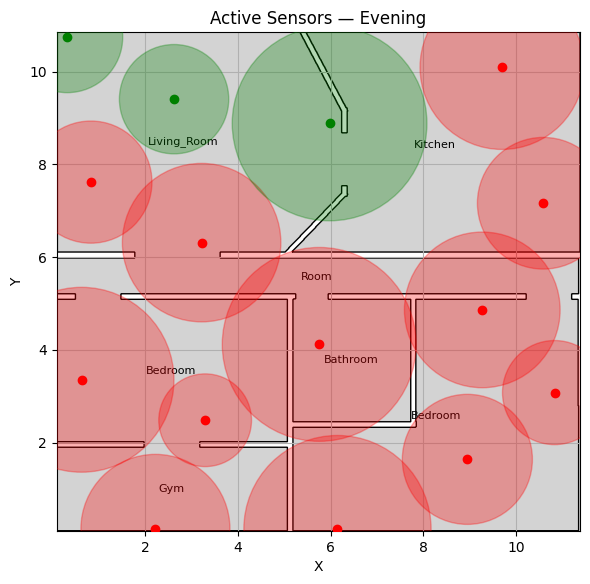

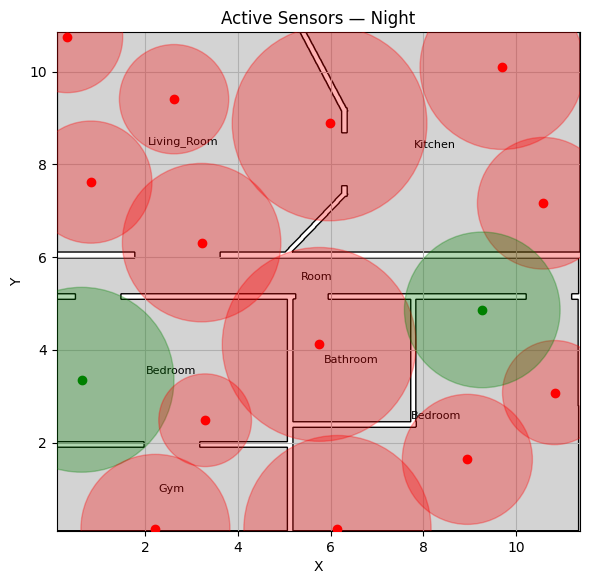

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import pprint
import time

# ------------ Load Layout and Sensor Data ------------
with open("layout.json", "r") as f:
    layout_data = json.load(f)
polygon_coords = layout_data["verts"]
room_boxes    = layout_data["room_category"]
min_x, min_y  = layout_data["bbox"]["min"]
max_x, max_y  = layout_data["bbox"]["max"]

# Load Phase 1 sensor placements
with open("phase1_sensors.json", "r") as f:
    sensor_data = json.load(f)
sensor_positions = np.array(sensor_data["sensors"])  # each is [x,y,r]

# ------------ Activity Levels Prompt ------------
time_blocks = ["Morning", "Afternoon", "Evening", "Night"]
activity_levels = {t: {} for t in time_blocks}
print("Enter activity levels (0.0–1.0):")
for t in time_blocks:
    print(f"\n– {t}")
    for room in room_boxes:
        while True:
            try:
                v = float(input(f"  {room}: "))
                if 0.0 <= v <= 1.0:
                    activity_levels[t][room] = v
                    break
            except ValueError:
                pass
            print("   → Enter a number between 0.0 and 1.0.")
print("\nFinal activity levels:")
pprint.pprint(activity_levels)

# ------------ Prepare Grid & Labels ------------
grid_res = 0.2
xs = np.arange(min_x, max_x, grid_res)
ys = np.arange(min_y, max_y, grid_res)
xx, yy = np.meshgrid(xs, ys)
GRID = np.c_[xx.ravel(), yy.ravel()]

room_label_map = np.full(len(GRID), "", dtype=object)
for room, boxes in room_boxes.items():
    for x1,y1,x2,y2 in boxes:
        m = (GRID[:,0]>=x1)&(GRID[:,0]<=x2)&(GRID[:,1]>=y1)&(GRID[:,1]<=y2)
        room_label_map[m] = room

# ------------ Activation Evaluation ------------
def evaluate_mask(mask, tkey):
    cov = np.zeros(len(GRID), dtype=float)
    for i,on in enumerate(mask):
        if not on: continue
        x0,y0,r = sensor_positions[i]
        d = np.hypot(GRID[:,0]-x0, GRID[:,1]-y0)
        cov += (d<=r).astype(float)
    weights = np.array([activity_levels[tkey].get(rm,0.0) for rm in room_label_map])
    weighted_cov = np.sum((cov>0)*weights)
    cost = np.sum(mask)
    overlap = np.sum(cov) - np.sum(cov>0)
    return weighted_cov, cost, overlap

# ------------ PSO + GA Optimization ------------
def optimize_activation_pso_ga(time_key,
                                swarm_size=30,
                                max_iter=50,
                                w=0.7,
                                c1=1.5,
                                c2=1.5,
                                beta=1.0,
                                ga_pop=20,
                                ga_gen=30,
                                ga_crossover=0.8,
                                ga_mutation=0.1):
    N = len(sensor_positions)
    # Initialize binary swarm and velocity
    pos = np.random.randint(0,2,(swarm_size,N))
    vel = np.zeros((swarm_size,N), dtype=float)
    pbest = pos.copy()
    pbest_val = np.full(swarm_size, np.inf)
    gbest = pos[0].copy()
    gbest_val = np.inf

    # PSO global search
    for _ in range(max_iter):
        for i in range(swarm_size):
            mask = pos[i].astype(bool)
            cov,cost,ov = evaluate_mask(mask, time_key)
            fitness = (cost + beta*ov)/(cov + 1e-6)
            if fitness < pbest_val[i]:
                pbest_val[i] = fitness
                pbest[i] = pos[i].copy()
            if fitness < gbest_val:
                gbest_val = fitness
                gbest = pos[i].copy()
        # PSO velocity & position update (binary)
        r1 = np.random.rand(swarm_size,N)
        r2 = np.random.rand(swarm_size,N)
        vel = w*vel + c1*r1*(pbest-pos) + c2*r2*(gbest-pos)
        prob = 1/(1+np.exp(-vel))
        pos = (np.random.rand(swarm_size,N) < prob).astype(int)

    # GA local refinement on gbest
    pop = [gbest.copy() for _ in range(ga_pop)]
    pop_fitness = []
    for ind in pop:
        cov,cost,ov = evaluate_mask(ind.astype(bool), time_key)
        pop_fitness.append((cost + beta*ov)/(cov + 1e-6))

    for _ in range(ga_gen):
        new_pop = []
        for _ in range(ga_pop//2):
            i1,i2 = np.random.choice(len(pop),2,replace=False)
            parent1 = pop[i1] if pop_fitness[i1] < pop_fitness[i2] else pop[i2]
            i3,i4 = np.random.choice(len(pop),2,replace=False)
            parent2 = pop[i3] if pop_fitness[i3] < pop_fitness[i4] else pop[i4]
            if np.random.rand() < ga_crossover:
                cx = np.random.randint(1, N)
                child1 = np.concatenate([parent1[:cx], parent2[cx:]])
                child2 = np.concatenate([parent2[:cx], parent1[cx:]])
            else:
                child1, child2 = parent1.copy(), parent2.copy()
            for child in (child1, child2):
                for bit in range(N):
                    if np.random.rand() < ga_mutation:
                        child[bit] = 1 - child[bit]
                new_pop.append(child)
        pop = []
        pop_fitness = []
        for ind in new_pop:
            cov,cost,ov = evaluate_mask(ind.astype(bool), time_key)
            f = (cost + beta*ov)/(cov + 1e-6)
            pop.append(ind)
            pop_fitness.append(f)
    idx = int(np.argmin(pop_fitness))
    best_mask = pop[idx]
    return best_mask.astype(bool)

# ------------ Run & Save Phase 2 Results ------------
phase2 = {}
for t in time_blocks:
    start = time.perf_counter()
    mask = optimize_activation_pso_ga(t)
    duration = time.perf_counter() - start
    cov, cost, ov = evaluate_mask(mask, t)
    phase2[t] = {
        "active_mask": mask.tolist(),
        "active_count": int(cost),
        "weighted_coverage": float(cov),
        "overlap_penalty": float(ov),
        "runtime_s": round(duration, 3)
    }
    print(f"Time slot '{t}': PSO+GA runtime = {duration:.2f}s")

with open("phase2_results.json","w") as f:
    json.dump(phase2, f, indent=2)

# ------------ Visualization ------------
for t, data in phase2.items():
    mask = np.array(data["active_mask"])
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_aspect('equal'); ax.set_title(f"Active Sensors — {t}")
    ax.add_patch(Polygon(polygon_coords, closed=True, facecolor='lightgray', edgecolor='black', zorder=1))

    for room, boxes in room_boxes.items():
        if room.lower() == 'toilet':
            continue
        for x1, y1, x2, y2 in boxes:
            xc, yc = (x1 + x2)/2, (y1 + y2)/2
            ax.text(xc, yc, room, ha='center', va='center', fontsize=8, color='black', zorder=2)

    for i, on in enumerate(mask):
        x0, y0, r = sensor_positions[i]
        c = 'green' if on else 'red'
        ax.add_patch(plt.Circle((x0, y0), r, color=c, alpha=0.3, zorder=3))
        ax.plot(x0, y0, 'o', color=c, zorder=4)

    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)

    ax.grid(True, zorder=0)
    ax.set_xlabel('X'); ax.set_ylabel('Y')
    plt.tight_layout(); plt.show()


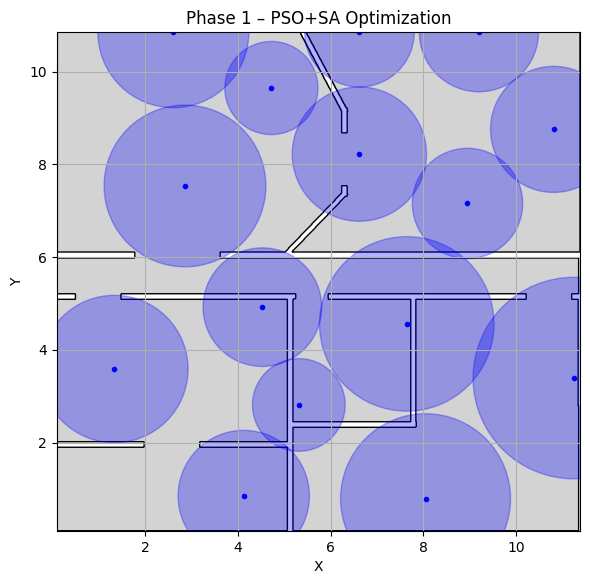

In [58]:
#####phaseone-paso+sa
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.path import Path

# --------------------- Load Layout ---------------------
with open("layout.json", "r") as f:
    layout_data = json.load(f)
polygon_coords = layout_data["verts"]
min_x, min_y   = layout_data["bbox"]["min"]
max_x, max_y   = layout_data["bbox"]["max"]
layout_poly    = Path(polygon_coords)

# --------------------- Parameters ---------------------
num_sensors         = 15
sensor_radius_bounds = (1.0, 2.5)
num_particles       = 30
num_iterations      = 80

# PSO hyperparams
w_inertia     = 0.7
c1, c2        = 1.4, 1.4

# SA hyperparams
sa_iter      = 50
sa_temp      = 1.0
sa_decay     = 0.9
noise_scale  = 0.1  # fraction of (ub-lb)

# Overlap & radius penalties
w_overlap      = 2.0
w_overlap_pts  = 1.0
w_radius       = 0.1

# --------------------- Prepare Grid ---------------------
grid_resolution = 0.2
x_coords = np.arange(min_x, max_x, grid_resolution)
y_coords = np.arange(min_y, max_y, grid_resolution)
xx, yy  = np.meshgrid(x_coords, y_coords)
GRID    = np.c_[xx.ravel(), yy.ravel()]
valid   = layout_poly.contains_points(GRID)

# --------------------- Fitness Function ---------------------
def evaluate_solution(sol):
    cov = np.zeros(len(GRID), dtype=int)
    radius_cost = 0.0
    # accumulate coverage & cost
    for i in range(num_sensors):
        x, y, r = sol[3*i:3*i+3]
        if not layout_poly.contains_point((x, y)):
            return np.inf
        d = np.hypot(GRID[:,0]-x, GRID[:,1]-y)
        mask = (d <= r)
        cov += mask.astype(int)
        radius_cost += r
    cov = cov * valid
    unique_cov   = np.sum(cov > 0)
    overlap_cov  = np.sum(cov) - unique_cov
    overlap_pts  = np.sum(cov > 1)
    # objective: minimize
    return (
        - unique_cov
        + w_overlap * overlap_cov
        + w_overlap_pts * overlap_pts
        + w_radius * radius_cost
    )

# --------------------- PSO + SA Optimization ---------------------
def optimize_pso_sa():
    dim = num_sensors * 3
    lb = np.tile([min_x, min_y, sensor_radius_bounds[0]], num_sensors)
    ub = np.tile([max_x, max_y, sensor_radius_bounds[1]], num_sensors)
    # initialize
    pos = np.random.uniform(lb, ub, (num_particles, dim))
    vel = np.zeros_like(pos)
    pbest = pos.copy()
    pval  = np.array([evaluate_solution(p) for p in pos])
    gbest = pbest[np.argmin(pval)].copy()
    gval  = np.min(pval)
    # PSO loop
    for _ in range(num_iterations):
        for i in range(num_particles):
            # update velocity & position
            r1, r2 = np.random.rand(dim), np.random.rand(dim)
            vel[i] = (
                w_inertia * vel[i]
                + c1 * r1 * (pbest[i] - pos[i])
                + c2 * r2 * (gbest - pos[i])
            )
            pos[i] += vel[i]
            pos[i] = np.minimum(np.maximum(pos[i], lb), ub)
            # evaluate
            f = evaluate_solution(pos[i])
            if f < pval[i]:
                pval[i] = f
                pbest[i] = pos[i].copy()
                if f < gval:
                    gval = f
                    gbest = pos[i].copy()
    # SA refinement on gbest
    best_sol = gbest.copy()
    best_val = gval
    T = sa_temp
    # scale vector for noise
    scale = noise_scale * (ub - lb)
    for _ in range(sa_iter):
        cand = best_sol + np.random.normal(scale=scale)
        cand = np.minimum(np.maximum(cand, lb), ub)
        f_cand = evaluate_solution(cand)
        if f_cand < best_val or np.random.rand() < np.exp((best_val - f_cand)/T):
            best_val = f_cand
            best_sol = cand.copy()
        T *= sa_decay
    return best_sol

# --------------------- Run Phase 1 Optimization ---------------------
best = optimize_pso_sa()
# save sensors
sensor_positions = []
for i in range(num_sensors):
    x, y, r = best[3*i:3*i+3]
    sensor_positions.append([x, y, r])
with open("phase1_sensors.json", "w") as f:
    json.dump({"sensors": sensor_positions}, f, indent=2)

# --------------------- Visualization ---------------------
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect("equal")
ax.add_patch(Polygon(polygon_coords, closed=True, facecolor="lightgray", edgecolor="black"))
for x, y, r in sensor_positions:
    ax.add_patch(plt.Circle((x, y), r, color='blue', alpha=0.3))
    ax.plot(x, y, 'bo', markersize=3)
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
ax.set_xlabel("X"); ax.set_ylabel("Y")
ax.grid(True)
plt.title("Phase 1 – PSO+SA Optimization")
plt.tight_layout()
plt.show()


Enter activity levels (0.0–1.0):

– Morning
  Living_Room: 1
  Kitchen: 1
  Room: 1
  Bedroom: 1
  Toilet: 1
  Bathroom: 1
  Gym: 1

– Afternoon
  Living_Room: 1
  Kitchen: 1
  Room: 1
  Bedroom: 1
  Toilet: 1
  Bathroom: 
   → Enter a number between 0.0 and 1.0.
  Bathroom: 1
  Gym: 1

– Evening
  Living_Room: 1
  Kitchen: 1
  Room: 1
  Bedroom: 1
  Toilet: 1
  Bathroom: 1
  Gym: 1

– Night
  Living_Room: 1
  Kitchen: 1
  Room: 1
  Bedroom: 1
  Toilet: 1
  Bathroom: 1
  Gym: 1

Final activity levels:
{'Afternoon': {'Bathroom': 1.0,
               'Bedroom': 1.0,
               'Gym': 1.0,
               'Kitchen': 1.0,
               'Living_Room': 1.0,
               'Room': 1.0,
               'Toilet': 1.0},
 'Evening': {'Bathroom': 1.0,
             'Bedroom': 1.0,
             'Gym': 1.0,
             'Kitchen': 1.0,
             'Living_Room': 1.0,
             'Room': 1.0,
             'Toilet': 1.0},
 'Morning': {'Bathroom': 1.0,
             'Bedroom': 1.0,
             'Gym'

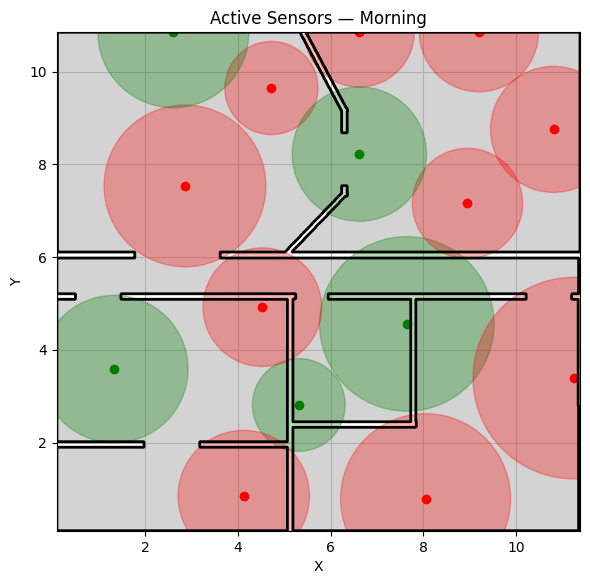

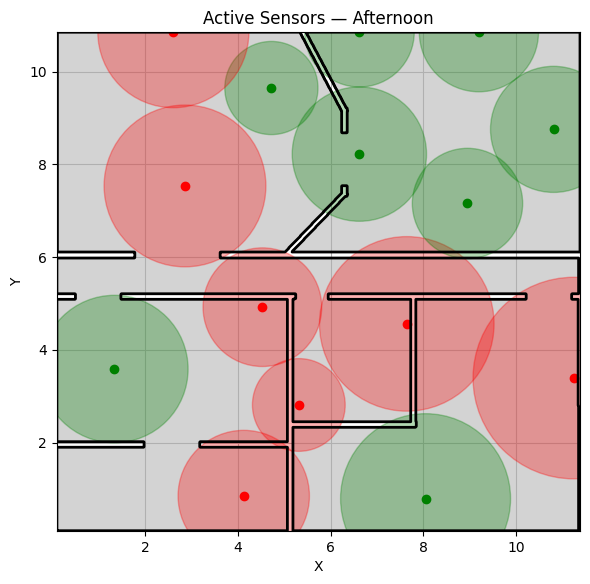

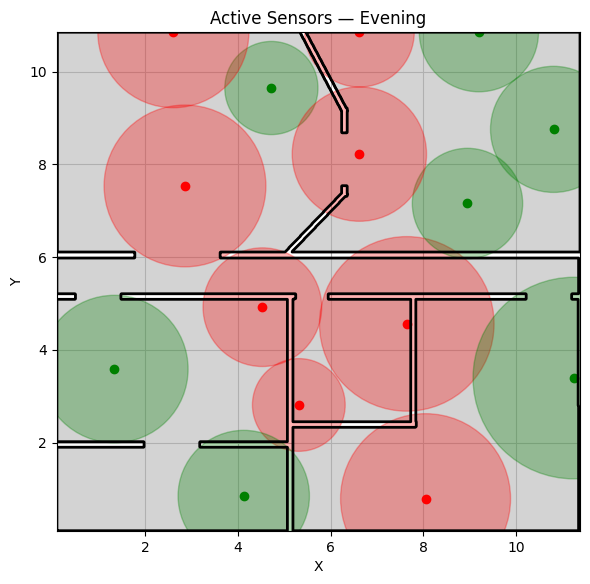

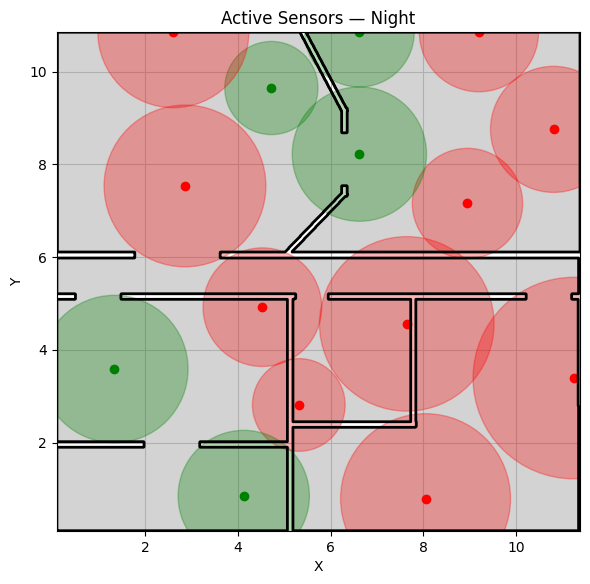

In [59]:
# ####PSO+SA
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import pprint

# ------------ Load Layout and Sensor Data ------------
with open("layout.json", "r") as f:
    layout_data = json.load(f)
polygon_coords = layout_data["verts"]
room_boxes    = layout_data["room_category"]
min_x, min_y  = layout_data["bbox"]["min"]
max_x, max_y  = layout_data["bbox"]["max"]

# Load Phase 1 sensor placements
with open("phase1_sensors.json", "r") as f:
    sensor_data = json.load(f)
sensor_positions = np.array(sensor_data["sensors"])  # each is [x,y,r]

# ------------ Activity Levels Prompt ------------
time_blocks = ["Morning", "Afternoon", "Evening", "Night"]
activity_levels = {t: {} for t in time_blocks}
print("Enter activity levels (0.0–1.0):")
for t in time_blocks:
    print(f"\n– {t}")
    for room in room_boxes:
        while True:
            try:
                v = float(input(f"  {room}: "))
                if 0.0 <= v <= 1.0:
                    activity_levels[t][room] = v
                    break
            except ValueError:
                pass
            print("   → Enter a number between 0.0 and 1.0.")
print("\nFinal activity levels:")
pprint.pprint(activity_levels)

# ------------ Prepare Grid & Labels ------------
grid_res = 0.2
xs = np.arange(min_x, max_x, grid_res)
ys = np.arange(min_y, max_y, grid_res)
xx, yy = np.meshgrid(xs, ys)
GRID = np.c_[xx.ravel(), yy.ravel()]

room_label_map = np.full(len(GRID), "", dtype=object)
for room, boxes in room_boxes.items():
    for x1,y1,x2,y2 in boxes:
        m = (GRID[:,0]>=x1)&(GRID[:,0]<=x2)&(GRID[:,1]>=y1)&(GRID[:,1]<=y2)
        room_label_map[m] = room

# ------------ Activation Evaluation ------------
def evaluate_mask(mask, tkey):
    cov = np.zeros(len(GRID), dtype=float)
    for i,on in enumerate(mask):
        if not on: continue
        x0,y0,r = sensor_positions[i]
        d = np.hypot(GRID[:,0]-x0, GRID[:,1]-y0)
        cov += (d<=r).astype(float)
    weights = np.array([activity_levels[tkey].get(rm,0.0) for rm in room_label_map])
    weighted_cov = np.sum((cov>0)*weights)
    cost = np.sum(mask)
    overlap = np.sum(cov) - np.sum(cov>0)
    return weighted_cov, cost, overlap

# ------------ PSO + SA Optimization ------------
def optimize_activation_pso_sa(time_key,
                                swarm_size=30,
                                max_iter=50,
                                w=0.7,
                                c1=1.5,
                                c2=1.5,
                                beta=1.0,
                                sa_iter=100,
                                sa_temp=1.0,
                                sa_decay=0.95):
    N = len(sensor_positions)
    # Initialize binary swarm and velocity
    pos = np.random.randint(0,2,(swarm_size,N))
    vel = np.zeros((swarm_size,N), dtype=float)
    pbest = pos.copy()
    pbest_val = np.full(swarm_size, np.inf)
    gbest = pos[0].copy()
    gbest_val = np.inf

    # PSO loop
    for _ in range(max_iter):
        for i in range(swarm_size):
            mask = pos[i].astype(bool)
            cov,cost,ov = evaluate_mask(mask, time_key)
            fitness = (cost + beta*ov)/ (cov + 1e-6)
            if fitness < pbest_val[i]:
                pbest_val[i] = fitness; pbest[i] = pos[i].copy()
            if fitness < gbest_val:
                gbest_val = fitness; gbest = pos[i].copy()
        # PSO update
        r1 = np.random.rand(swarm_size,N)
        r2 = np.random.rand(swarm_size,N)
        vel = w*vel + c1*r1*(pbest-pos) + c2*r2*(gbest-pos)
        prob = 1/(1+np.exp(-vel))
        pos = (np.random.rand(swarm_size,N) < prob).astype(int)

    # Simulated Annealing refinement on gbest
    best_mask = gbest.copy()
    best_val = gbest_val
    T = sa_temp
    for _ in range(sa_iter):
        # neighbor by flipping one bit
        cand = best_mask.copy()
        idx = np.random.randint(N)
        cand[idx] = 1-cand[idx]
        cov,cost,ov = evaluate_mask(cand.astype(bool), time_key)
        val = (cost + beta*ov)/(cov+1e-6)
        if val < best_val or np.random.rand() < np.exp((best_val-val)/T):
            best_val = val; best_mask = cand.copy()
        T *= sa_decay
    return best_mask.astype(bool)

# ------------ Run & Save Phase 2 Results ------------
import time
phase2 = {}
times = {}
for t in time_blocks:
    start = time.perf_counter()
    mask = optimize_activation_pso_sa(t)
    duration = time.perf_counter() - start
    cov, cost, ov = evaluate_mask(mask, t)
    phase2[t] = {
        "active_mask": mask.tolist(),
        "active_count": int(cost),
        "weighted_coverage": float(cov),
        "overlap_penalty": float(ov),
        "runtime_s": round(duration, 3)
    }
    print(f"Time slot '{t}': PSO+SA runtime = {duration:.2f}s")

with open("phase2_results.json","w") as f:
    json.dump(phase2,f,indent=2)
    json.dump(phase2,f,indent=2)

# ------------ Visualization ------------
for t, data in phase2.items():
    mask = np.array(data["active_mask"])
    fig,ax = plt.subplots(figsize=(6,6))
    ax.set_aspect('equal'); ax.set_title(f"Active Sensors — {t}")
    ax.add_patch(Polygon(polygon_coords,closed=True,facecolor='lightgray',edgecolor='black',zorder=1))
    for i,on in enumerate(mask):
        x0,y0,r = sensor_positions[i]
        c = 'green' if on else 'red'
        ax.add_patch(plt.Circle((x0,y0),r,color=c,alpha=0.3,zorder=2))
        ax.plot(x0,y0,'o',color=c,zorder=3)
    xs,ys = zip(*polygon_coords);
    xs,ys = list(xs)+[xs[0]], list(ys)+[ys[0]]
    ax.plot(xs,ys,color='black',linewidth=2,zorder=4)
    ax.set_xlim(min_x,max_x); ax.set_ylim(min_y,max_y)
    ax.grid(True,zorder=0)
    ax.set_xlabel('X'); ax.set_ylabel('Y')

    plt.tight_layout(); plt.show()
